# Cross-resonance gate between a transmon and a fluxonium: echo pulse

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium using an echo pulse as in Phys. Rev. A 102, 042605 (2020)

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import pauli_by_index, weyl_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json
import cmath
import util_tf_cr

from IPython.display import display, Latex

In [2]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [25]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "CR_4"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq= 5.5, #parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"],
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"],  
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

flx_a = pysqkit.qubits.Fluxonium(
    label='F_A', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"],  
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx_a.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx_a.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f_first_pulse',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
coupled_sys_a = transm.couple_to(flx_a, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system_a = transm.couple_to(flx_a, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

flx_freq = flx_a.eig_energies(2)[1] - flx_a.eig_energies(2)[0]

In [26]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys_a.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

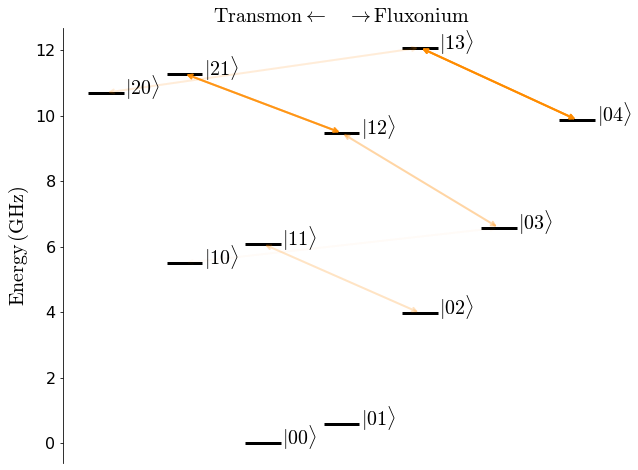

In [27]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util_tf_cr.energy_levels_diagram(bare_system_a, level_list, show_drive=False)

In [28]:
# The following functions can also be found in the util_tf_cr.py file and are here reported for clarity
# of the notebook

def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2*eps/2

def mu_zy_transm(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the transmon
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['01'])
    yz1 = get_mat_elem(op, comp_states['10'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the direct drive on the transmon numerically in the dressed basis 
    when driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2*eps/2

def mu_yz_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float,
    eps: float
):
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient via the second order Schrieffer-Wolff
    transformation
    """
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += -q_30**2/(omega_flx[3] - omega_t)
    coeff += q_10**2/(omega_t - omega_flx[1]) 
    mu_yz = jc*q_zpf*coeff/2*eps/2
    return mu_yz

In [29]:
eps_test = 0.3
display(Latex(r'$f_{{flx}} = {:.3f} \, \mathrm{{MHz}}$'.format(flx_freq*1e3)))
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*zz(coupled_sys_a))))
q_op = coupled_sys_a["F_A"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{YZ}}^{{(SW)}} = {:.4f} $'.format(mu_yz_flx_sw(transm, flx_a, jc, eps_test*1e3))))
display(Latex(r'$\mu_{{YI}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{ZY}} = {:.6f} $'.format(mu_zy_transm(comp_states, q_op, eps_test*1e3))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We will apply an echo pulse of the form 

$$
U_{echo} = e^{i \pi I Y/2} U_{CR}(-\varepsilon_d, t_{\mathrm{gate}/2}) e^{-i \pi I Y/2}U_{CR}(\varepsilon_d, t_{\mathrm{gate}/2})
$$

In [30]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/4)  

def func_to_minimize_echo(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/8)  
    

In [31]:
eps = 0.5
omega_flx, states_flx = flx_a.eig_states(4)
op = coupled_sys_a["F_A"].charge_op()
freq_drive = transm.max_freq
t_rise = 10.0 # [ns]
cr_coeff = np.abs(mu_yz_flx(comp_states, op, eps))

t_gate_0 = [util_tf_cr.cr_gate_time(cr_coeff)]
t_pulse_0_echo = [t_gate_0[0]/2]

args_to_pass = (t_rise, cr_coeff) 
# We find the total time to obtain the desired gate

start = time.time()

minimization_result = minimize(func_to_minimize, t_gate_0, args=args_to_pass)
minimization_result_echo = minimize(func_to_minimize_echo, t_pulse_0_echo, args=args_to_pass)

print(minimization_result)

end = time.time()

t_gate = minimization_result['x'][0] 
t_pulse_echo = minimization_result_echo['x'][0] 
print("t_gate: {} ns".format(t_gate))
print("t_gate_echo: {} ns".format(t_pulse_echo))
pts_per_drive_period = 10

nb_points = int(t_gate*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_gate, nb_points)
tlist_echo = np.linspace(0, t_pulse_echo, int(nb_points/2))

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, 
                                                 rise_time=t_rise, pulse_time=t_gate, 
                                                 amp=eps, freq=freq_drive)

coupled_sys_a['F_A'].drives['cr_drive_f_first_pulse'].set_params(phase=0, time=tlist_echo, 
                                                                 rise_time=t_rise, pulse_time=t_pulse_echo, 
                                                                 amp=eps, freq=freq_drive)


      fun: 3.1385560816943325e-11
 hess_inv: array([[1.75633739e-06]])
      jac: array([2.92882323e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 90
      nit: 2
     njev: 39
   status: 2
  success: False
        x: array([195.73754215])
t_gate: 195.7375421502442 ns
t_gate_echo: 103.15829661179568 ns


In [32]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-14
simu_opt.rtol = 1e-12

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                        with_noise=False, dressed_noise=False)

env_syst_a = pysqkit.tomography.TomoEnv(system=coupled_sys_a, time=2*np.pi*tlist_echo, options=simu_opt, 
                                        with_noise=False, dressed_noise=False)

In [33]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

In [34]:
avg_leakage = env_syst.leakage(comp_states_list)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

In [35]:
n_process = 8

my_hs_basis = pauli_by_index

start = time.time()
sup_op_first = env_syst_a.to_super(comp_states_list, my_hs_basis, n_process, speed_up=True)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 84.7377417087555 s


In [36]:
sq_corr_first = util_tf_cr.single_qubit_corrections(sup_op_first, my_hs_basis)
sq_corr_sup_first = trf.kraus_to_super(sq_corr_first, my_hs_basis)
sup_op_first_tot = sq_corr_sup_first.dot(sup_op_first) 

In [37]:
flx_b = pysqkit.qubits.Fluxonium(
    label='F_B', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"],  
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=thermal_energy,
    dephasing_times=None 
)
flx_b.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx_b.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f_second_pulse',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

coupled_sys_b = transm.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

coupled_sys_b['F_B'].drives['cr_drive_f_second_pulse'].set_params(phase=0, time=tlist_echo, 
                                                                 rise_time=t_rise, pulse_time=t_pulse_echo, 
                                                                 amp=-eps, freq=freq_drive)

env_syst_b = pysqkit.tomography.TomoEnv(system=coupled_sys_b, time=2*np.pi*tlist_echo, options=simu_opt, 
                                        with_noise=False, dressed_noise=False)

In [38]:
start = time.time()
sup_op_second = env_syst_b.to_super(comp_states_list, my_hs_basis, n_process, speed_up=True)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 83.02185225486755 s


In [39]:
sq_corr_second = util_tf_cr.single_qubit_corrections(sup_op_second, my_hs_basis)
sq_corr_sup_second = trf.kraus_to_super(sq_corr_second, my_hs_basis)
sup_op_second_tot = sq_corr_sup_second.dot(sup_op_second) 

In [40]:
def ry_t(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

def rx_t(theta):
    rot_x = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, 1], [1, 0]])
    return np.kron(rot_x, np.identity(2))

def ry_f(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(np.identity(2), rot_y)

sup_echo = trf.kraus_to_super(ry_f(np.pi), my_hs_basis)

In [41]:
total_sup_op = sup_echo.dot(sup_op_second_tot.dot(sup_echo.dot(sup_op_first_tot)))

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis. This can be done via the function qutip.util.transformations.kraus_to_super

In [42]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

theta_list = list(np.linspace(0, 2*np.pi, 100))

We can now compute the process fidelity

In [43]:
cr_super_target = trf.kraus_to_super(cry(-np.pi/2), my_hs_basis)
f_pro = average_process_fidelity(cr_super_target, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement. Since during the gate also an unwanted $Y$ rotations is implemented let us try to virtually correct it. In particular, we look for the $Y$ rotation on the transmon that maximized the fidelity.

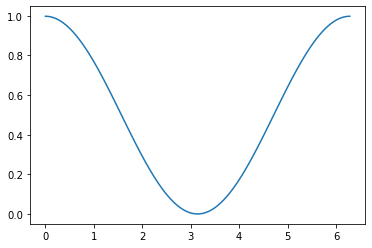

<IPython.core.display.Latex object>

In [44]:
fid_list_ry = []
for theta in theta_list:
    rot_y_super = trf.kraus_to_super(ry_t(theta), my_hs_basis)
    fid_list_ry.append(average_process_fidelity(cr_super_target, rot_y_super.dot(total_sup_op)))

fid_ry = np.array(fid_list_ry)

plt.plot(theta_list, fid_ry)
plt.show()
max_fid = np.max(fid_ry)
max_index = np.argmax(fid_ry)
sup_rot_y_opt = trf.kraus_to_super(ry_t(theta_list[max_index]), my_hs_basis)
display(Latex(r"Maximum achievable fidelity after ideal $Y$ rotations = ${}$".format(max_fid)))

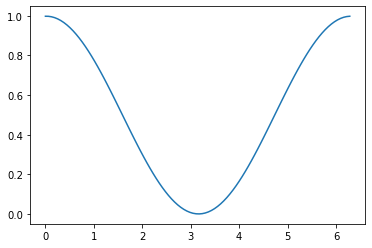

<IPython.core.display.Latex object>

In [45]:
fid_list_rx = []
for theta in theta_list:
    rot_x_super = trf.kraus_to_super(rx_t(theta), my_hs_basis)
    fid_list_rx.append(average_process_fidelity(cr_super_target, rot_x_super.dot(total_sup_op)))

fid_rx = np.array(fid_list_rx)

plt.plot(theta_list, fid_rx)
plt.show()
max_fid = np.max(fid_rx)
max_index = np.argmax(fid_rx)
sup_rot_x_opt = trf.kraus_to_super(rx_t(theta_list[max_index]), my_hs_basis)
display(Latex(r"Maximum achievable fidelity after ideal $X$ rotations = ${}$".format(max_fid)))

The average leakage and seepage is instead computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively. 

Finally, the average gate fidelity is

In [46]:
total_sup_op_ry = sup_rot_y_opt.dot(total_sup_op)
f_gate = average_gate_fidelity(cr_super_target, total_sup_op_ry, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>

It is clear that the main source of error is leakage. Let us thus check where the leakage is coming from mainly.

# Leakage analysis

To study leakage we consider the noiseless case

In [157]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init: qtp.qobj.Qobj, 
    options: qtp.solver.Options=None
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op, "mesolve", options=options)
                    
    return result  

In [158]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states_list, np.conj(comp_states_list))
subsys_dims = list(q.dim_hilbert for q in coupled_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist, system=coupled_sys, state_init=proj_comp/d_comp, options=simu_opt)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [159]:
comp_state_label = ['00', '01', '10', '11']
leakage_states = []
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        if str(lev_t) + str(lev_f) not in comp_state_label:
            leakage_states.append(str(lev_t) + str(lev_f))

In [160]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob

In [161]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We notice that leakage is quite heterogeneous in the sense that many levels are a bit populated. I think this problem can be solved by several strategies such as optimizing the coupling, increasing the gate time or by taking larger frequency differences between the transmon and the higher levels of the fluxonium. Indeed, by reducing the coupling, at the price of a doubled gate time for fixed drive strength, we have much less leakage.